In [50]:
# Import needed packages
import numpy as np
import matplotlib.pyplot as plt

## Example: Noisy Sphere Function

Let $f: R^N \to R$ equal the sphere function; i.e., $$f(x; \xi)=\sum_{i=1}^N x_i^2 + \epsilon (\xi),$$ where $\epsilon \sim U[-k,k]$ is stoachastic additive noise with zero mean and bounded variance. Then we have $\nabla f(x)=2x$ and one can show that $L_1^*=2$. This means that the value of $||\nabla f(x) -\nabla f(y)||$ will never be larger than twice the value of $2||x-y||$ which is obvious because $||\nabla f(x) -\nabla f(y)||$ literally equals $2||x-y||$.

In [51]:
# Define sphere function with additive noise

# Noise level
k=1e-4

def sphere(x):
    x=x**2
    return (np.sum(x, axis=0) + k*(2*np.random.rand(1) - 1))[0]

F=sphere # rename function as F due to other code

N=50 # this is the dimension of the inputs!

x_test=np.sqrt(2)*np.ones(N)

print('Noisy sphere function evaluated at x_test is', F(x_test), 'and the error-free value is', 2*N)

Noisy sphere function evaluated at x_test is 99.99990211852962 and the error-free value is 100


### STEP 1: Estimate the standard deviation of the noise, $\sigma_\epsilon^2$

Since $\epsilon(\cdot) \sim U[-k,k]$, the variance in the rv $\epsilon(\cdot)$  is $\sigma_\epsilon ^2 = k^2/3$. The below implementation of EC Noise (Chen & More) will form estimators to $\sigma_\epsilon^2 $.

In [52]:
# What's the right answer?

correct_var=k**2/3

print('True variance is', correct_var)

True variance is 3.3333333333333334e-09


In [62]:
# Initialize difference table which is M x M
# M is number of points to be sampled along some curve and evaluated under f(.)

M=6

T = np.zeros((M,M))

In [63]:
# Choose a base point:
# ie: the first point on the curve
x_b = np.ones((N,1))

# Choose a direction to sample in, and normalize it:
p_u = np.ones((N,1))
p = p_u/np.linalg.norm(p_u)

In [71]:
# Form difference table T

for i in range(0,M):
    T[i,0] = F(x_b + (i/M)*p)

for j in range(0,M-1):
    for i in range(0,M-j-1):
        T[i,j+1] = T[i+1,j] - T[i,j]

In [72]:
# Make a row vector to store the k-level estimators (sigma_k^2) 
# ie: Initialize empty vector for storage, row vector for readability

S = np.zeros((1,M))

In [73]:
# Build S according to paper; each k-th component of S is the k-th level estimator for the variance in our noise
# which is computed using a scaled average of the k-th level difference values, from the difference table T

for i in range(1,M):
    S[0,i] = ((np.math.factorial(i)**2.)/np.math.factorial(2*i))*(1./(M-i))*np.sum(T[:,i]**2,axis=0)

S=S[:,1:] # Don't need the first column (because first col. of T just holds function values!)

In [74]:
# Print our estimators

print(S)

[[3.11788671e+00 5.13022761e-04 4.15488266e-09 3.49472777e-09
  2.85679839e-09]]


In [75]:
# How did we do?
# ie: compute a vector of relative errors between correct variance and k-th level estimator

E = np.zeros((1,M-1))
for i in range(0,M-1):
    E[0,i] = (1./correct_var)*abs(S[0,i] - correct_var)

In [76]:
# Print the level, k, of the estimator with smallest relative error, and print the error
key_index=np.argmin(E)
print(key_index, S[0,key_index]) 

3 3.494727770818714e-09


In [77]:
# Define our estimated variance as the best one

est_var= S[0,key_index]
print(est_var)

3.494727770818714e-09


### STEP 2: Learn the $L_1$ Lipschitz constant

We first compute a value $\epsilon^*$ prescribed in a Callies paper which is a rough estimate of the the maximum contribution of error. For us, 3*(standard deviation) in the error will give an upper bound on 99.7% of error draws, on average.

In [21]:
std=est_var**0.5
eps_star=3*std
eps_star

0.00017017497335139256

Now we need a heuristic estimate for $||f''(x_0)||$ and it can be a very rough upper bound -- Chen and More show this experimentally. The following is directly adapted from Algorithm 5.1 in More and Wild.

In [78]:
# Suggested parameters for an inequality we will test
tao_1=100
tao_2=0.1

# We need a random draw
x_0=100*(2*np.random.rand(N,1) - np.ones((N,1)))

# Define an arbitrary unit vector
unit_v=np.ones(N)/(N**(1/N))

# Computes a centered finite difference to approximate f''
# Stores all 3 function evaluations
def Delta(h):
    F_m=F(x_0 - h*unit_v)
    F_0=F(x_0)
    F_p=F(x_0 + h*unit_v)
    return np.array((abs(F_m - 2*F_0 + F_p), F_m, F_0, F_p))

# Name some of the things we just made
h_a=std**0.25
DD=Delta(h_a)
D_h_a=DD[0]
F_m_a=DD[1]
F_0_a=DD[2]
F_p_a=DD[3]

# Our first candidate for ||f''||
mu_a=D_h_a/(h_a**2)

# The LHS and RHS from two inequalities we need to test
LHS_1=abs(F_p_a-F_0_a)
LHS_2=abs(F_m_a-F_0_a)
RHS_1=tao_2*max(abs(F_0_a),abs(F_p_a))
RHS_2=tao_2*max(abs(F_0_a),abs(F_m_a))

# We will use our first guess mu_a, unless some inequalities fail
# then we will use mu_b, an alternate guess scaled by mu_a
if D_h_a/std>=tao_1 and LHS_1<=RHS_1 and LHS_2<=RHS_2:
    mu_f2=mu_a
else:
    h_b=(std/mu_a)**0.25
    mu_f2=Delta(h_b)[0]/h_b**2
    
print(mu_f2)

85.53909577964365


Now we need estimates for the gradients at sample points, which are denoted $\hat{\nabla f (x_k)}$. We do so by evaluating the forward difference in each $i$-th component of a sample $x$ to approximate the $i$-th partial derivative of $f$ evaluated at $x$, $$\frac{\partial f}{\partial x_i}(x)\approx \frac{f(x+ h^* \cdot e_i)-f(x)}{h^*} \quad h^*:=8^{1/4}\left(\frac{\sigma}{\mu_{f''}}\right)^{1/2} \quad \mu_{f''} \approx \max |f''| \quad e_i:=(0,\ldots,0,1,0,\ldots,0).$$ In our case, $\mu_{f''}=2$ since the Hessian of $f$, $\nabla^2 f$ is a $10 \times 10$ diagonal matrix with entries of 2 along the diagonal, and we are using the standard Euclidean norm. Note that the Frobenius norm equals $\sqrt{40}$.

Chen and More show that $h^*$ yields the best estimates to the partial derivates in an $\mathcal{L}_1$ sense.

With a pairs of estimates $||\nabla f(x_k)||, ||\nabla f(x_{k+1})||$ we form the ratios $$\frac{||\nabla f(x_k)-\nabla f(x_{k+1})||-2\epsilon^*}{x_k-x_{k+1}}$$ and take the maximum such ratio as a numerical estimate to $L_1$.

In [79]:
M=6

x_vals=np.zeros((N,1)) # matrix to store the vectors we randomly make

grads=np.zeros((N,1)) # matrix to store the gradients we approximate

ratios=np.zeros((M,1)) # vector storing the ratios we are intersted in!

h_star=(8**0.25)*np.sqrt(std/mu_f2) # the prescribed step size by Chen/More

for j in range(0,M):

    # Take two draws inside a large hypercube and store them
    x=100*(2*np.random.rand(N,1) - np.ones((N,1)))
    y=100*(2*np.random.rand(N,1) - np.ones((N,1)))
    x_vals=np.hstack((x_vals,x))
    x_vals=np.hstack((x_vals,y))

    # For loop to make finite diff approx's 
    # to each partial and form approx gradient at x
    approx_grad_x=np.zeros((N,1))
    for i in range(0,N):
        e = np.zeros((N,1))
        e[i] = 1.0
        approx_grad_x[i] = (F(x + h_star*e) - F(x))/h_star
    
    # Store the gradient at x
    grads=np.hstack((grads,approx_grad_x))
    
    # For loop to make finite diff approx's 
    # to each partial and form approx gradient at y
    approx_grad_y=np.zeros((N,1))
    for p in range(0,N):
        e = np.zeros((N,1))
        e[p] = 1.0
        approx_grad_y[p] = (F(y + h_star*e) - F(y))/h_star
    
    # Store the gradient at y
    grads=np.hstack((grads,approx_grad_y))
    
    # Form ratios to estimate L_1
    # Note we subtract by 2*eps_star, which was mentioned in Callies paper
    diff_1=np.linalg.norm(approx_grad_x - approx_grad_y) - 2*eps_star
    diff_2=np.linalg.norm(x-y)
    r=diff_1/diff_2
    
    ratios[j]=r
    
x_vals=x_vals[:,1:]
grads=grads[:,1:]

In [80]:
L_1_est=(np.max(ratios))

print('the ratios are', np.transpose(ratios),'and our estimate to L_1 is', L_1_est)

the ratios are [[1.99998943 1.99980899 1.99984239 1.99989853 1.99998135 1.99988401]] and our estimate to L_1 is 1.9999894280766328


#### We have now obtained estimates to both $\sigma_\epsilon^2$ and $L_1$.

### STEP 3: Perform STARs (with no bells and whistles)

Chen and Wild define the optimal hyperparameters $$\mu^* := \left(\frac{8\sigma_\epsilon^2 N}{L_1^2(N+6)^3}\right)^{1/4} \quad \quad h:= \frac{1}{4L_1(N+4),}$$ where $\mu^*$ as a smoothing factor and $h$ is a step size. We will use our estimates to $\sigma_\epsilon^2$ and $L_1$ to compute the hyperparameters needed for STARs.

In [81]:
mu_star=((8*est_var*N)/(L_1_est**2*(N+6)**3))**0.25
h=1/(4*L_1_est*(N+4))

print(mu_star,h)

0.0011877183474750595 0.00231482705090191


In [82]:
def STARS(x_init,F, mu_star,h):
    
    # x_init: initial x value
    # F: function we wish to minimize
    # mu_star: smoothing parameter
    # h: step length
    
    # Evaluate noisy F(x_init)
    f = F(x_init)
    
    # Draw a random vector of same size as x_init
    u = np.random.normal(0,1,(N,1))
    
    # Form vector y, which is a random walk away from x_init
    y = x_init + (mu_star)*u
    
    # Evaluate noisy F(y)
    g = F(y)
    
    # Form finite-difference "gradient oracle"
    s = ((g - f)/mu_star)*u 
    
    # Take descent step in direction of -s smooth by h to get next iterate, x_1
    x = x_init - (h)*s
   
    # Evaluate noisy F(x_1)
    f=F(x)
    
        
    return [x, f, y, g]

In [83]:
# Draw a single x_init to seed all experiments with same value below

x_init=100*(2*np.random.rand(N,1)-np.ones((N,1)))

print(np.shape(x_init),F(x_init))

(50, 1) 169042.2838376563


In [84]:
# Run pure STARs

x=x_init
f=F(x)

x_hist=np.array(x)
f_hist=np.array(f)

maxit=2000

for i in range(1, maxit):
    s=STARS(x,F,mu_star,h)
    x=s[0]
    f=s[1]
    x_hist=np.hstack((x_hist,x))
    f_hist=np.hstack((f_hist,f))
    
print(np.linalg.norm(x),f)

0.16791887437724354 0.028222529492468926


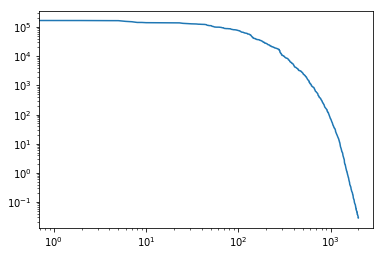

In [85]:
plt.loglog(f_hist)
plt.show()